### See the raw data

In [1]:
!ls /mnt/blobfuse/glaciers/analysis_images/ | wc -l 
!ls /mnt/blobfuse/glaciers/correction_images | wc -l 

73
23


In [2]:
!ls /mnt/blobfuse/glaciers/analysis_images | head -n 5

LE07_134040_20070922.tif
LE07_134040_20090927.tif
LE07_135040_20081102.tif
LE07_135040_20081118.tif
LE07_135040_20081204.tif


## make masking_paths config file

In [3]:
import pathlib

data_dirs = [pathlib.Path("/mnt/blobfuse/glaciers/correction_images") ,
            pathlib.Path("/mnt/blobfuse/glaciers/analysis_images")]
glacier_file = "/mnt/blobfuse/glaciers/pipeline_demo/demo_data/vector_data/2005/nepal/data/Glacier_2005.shp"
clean_glacier_file = "/mnt/blobfuse/glaciers/pipeline_demo/demo_data/vector_data/2005/nepal/data/clean.shp"
debris_glacier_file = "/mnt/blobfuse/glaciers/pipeline_demo/demo_data/vector_data/2005/nepal/data/debris.shp"

configs = {}
i = 0
for data_dir in data_dirs:
    for file_name in data_dir.iterdir():
        img_item = {}
        img_item["img_path"] = str(file_name)
        img_item["mask_paths"] = [glacier_file, clean_glacier_file, debris_glacier_file]
        configs[f"mask_{i}"] = img_item
        i += 1


In [4]:
# !mkdir /mnt/blobfuse/glaciers/conf
# !rm /mnt/blobfuse/glaciers/conf/masking_paths.yaml

import yaml
with open("/mnt/blobfuse/glaciers/conf/masking_paths.yaml", "w") as file:
    yaml.dump(configs, file)

## Mask images

In [16]:
!rm -rf /mnt/blobfuse/glaciers/processed/masks
from glacier_mapping.data.mask import generate_masks
import pathlib

conf_path = pathlib.Path("/mnt/blobfuse/glaciers/conf")
masking_paths = yaml.load(open(conf_path / "masking_paths.yaml"))
img_paths = [p["img_path"] for p in masking_paths.values()]
mask_paths = [p["mask_paths"] for p in masking_paths.values()]
generate_masks(img_paths, mask_paths, out_dir="/mnt/blobfuse/glaciers/processed/masks")

/home/shimaa/envs/glaciers_env/lib/python3.6/site-packages/ipykernel_launcher.py:6: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  


working on image 1 / 96
working on image 2 / 96
working on image 3 / 96
working on image 4 / 96
working on image 5 / 96
working on image 6 / 96
working on image 7 / 96
working on image 8 / 96
working on image 9 / 96
working on image 10 / 96
working on image 11 / 96
working on image 12 / 96
working on image 13 / 96
working on image 14 / 96
working on image 15 / 96
working on image 16 / 96
working on image 17 / 96
working on image 18 / 96
working on image 19 / 96
working on image 20 / 96
working on image 21 / 96
working on image 22 / 96
working on image 23 / 96
working on image 24 / 96
working on image 25 / 96
working on image 26 / 96
working on image 27 / 96
working on image 28 / 96
working on image 29 / 96
working on image 30 / 96
working on image 31 / 96
working on image 32 / 96
working on image 33 / 96
working on image 34 / 96
working on image 35 / 96
working on image 36 / 96
working on image 37 / 96
working on image 38 / 96
working on image 39 / 96
working on image 40 / 96
working o

## display results

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

mask_dir = pathlib.Path("/mnt/blobfuse/glaciers/processed", "masks")
mask = np.load(mask_dir / "mask_00.npy")
print(mask.shape)

mask_df = pd.read_csv(mask_dir / "mask_metadata.csv")
mask_df.head()

(7135, 7850, 3)


,id,img,mask,img_width,img_height,mask_width,mask_height
0,0,/mnt/blobfuse/glaciers/correction_images/LE07_...,/mnt/blobfuse/glaciers/processed/masks/mask_00...,7850,7135,7850,7135
1,1,/mnt/blobfuse/glaciers/correction_images/LE07_...,/mnt/blobfuse/glaciers/processed/masks/mask_01...,7865,7168,7865,7168
2,2,/mnt/blobfuse/glaciers/correction_images/LE07_...,/mnt/blobfuse/glaciers/processed/masks/mask_02...,7933,7205,7933,7205
3,3,/mnt/blobfuse/glaciers/correction_images/LE07_...,/mnt/blobfuse/glaciers/processed/masks/mask_03...,7937,7206,7937,7206
4,4,/mnt/blobfuse/glaciers/correction_images/LE07_...,/mnt/blobfuse/glaciers/processed/masks/mask_04...,8007,7260,8007,7260


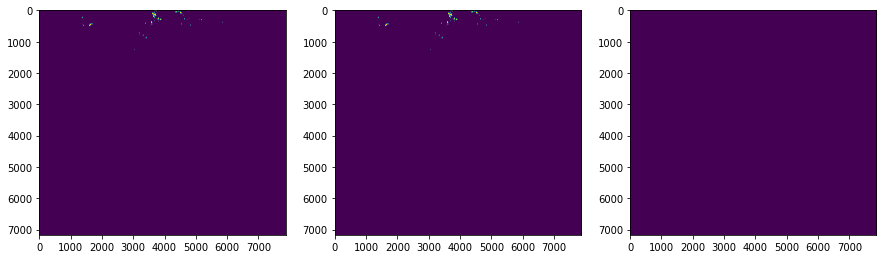

In [18]:
# glaciers, clean glaciers and debris glaciers
mask = np.load(mask_dir / "mask_01.npy")
_, ax = plt.subplots(1, 3, figsize=(15, 15))
ax[0].imshow(mask[:, :, 0])
ax[1].imshow(mask[:, :, 1])
ax[2].imshow(mask[:, :, 2])

## slice

In [19]:
import pandas as pd
from glacier_mapping.data.slice import write_pair_slices

processed_dir = pathlib.Path("/mnt/blobfuse/glaciers/processed/")
paths = pd.read_csv(processed_dir / "masks" / "mask_metadata.csv")
output_dir = processed_dir / "slices"
output_dir.mkdir(parents=True, exist_ok=True)

metadata = []
for row in range(len(paths)):
    print(f"## Slicing tiff {row +1}/{len(paths)} ...")
    metadata_ = write_pair_slices(
        paths.iloc[row]["img"],
        paths.iloc[row]["mask"],
        output_dir,
        f"slice_{paths.index[row]}"
    )
    metadata.append(metadata_)

metadata = pd.concat(metadata, axis=0)
out_path = pathlib.Path(output_dir, "slices.geojson")
metadata.to_file(out_path, index=False, driver="GeoJSON")

## Slicing tiff 1/96 ...


100%|██████████| 210/210 [03:33<00:00,  1.02s/it]


## Slicing tiff 2/96 ...


100%|██████████| 210/210 [03:28<00:00,  1.00it/s]


## Slicing tiff 3/96 ...


100%|██████████| 210/210 [03:40<00:00,  1.05s/it]


## Slicing tiff 4/96 ...


100%|██████████| 210/210 [03:46<00:00,  1.08s/it]


## Slicing tiff 5/96 ...


100%|██████████| 210/210 [03:54<00:00,  1.12s/it]


## Slicing tiff 6/96 ...


100%|██████████| 195/195 [03:42<00:00,  1.14s/it]


## Slicing tiff 7/96 ...


100%|██████████| 195/195 [03:40<00:00,  1.13s/it]


## Slicing tiff 8/96 ...


100%|██████████| 195/195 [03:59<00:00,  1.23s/it]


## Slicing tiff 9/96 ...


100%|██████████| 210/210 [04:02<00:00,  1.15s/it]


## Slicing tiff 10/96 ...


100%|██████████| 210/210 [03:49<00:00,  1.09s/it]


## Slicing tiff 11/96 ...


100%|██████████| 210/210 [03:41<00:00,  1.05s/it]


## Slicing tiff 12/96 ...


100%|██████████| 210/210 [03:20<00:00,  1.05it/s]


## Slicing tiff 13/96 ...


100%|██████████| 210/210 [03:26<00:00,  1.02it/s]


## Slicing tiff 14/96 ...


100%|██████████| 210/210 [03:27<00:00,  1.01it/s]


## Slicing tiff 15/96 ...


100%|██████████| 210/210 [03:37<00:00,  1.04s/it]


## Slicing tiff 16/96 ...


100%|██████████| 210/210 [03:33<00:00,  1.02s/it]


## Slicing tiff 17/96 ...


100%|██████████| 210/210 [03:21<00:00,  1.04it/s]


## Slicing tiff 18/96 ...


100%|██████████| 224/224 [03:29<00:00,  1.07it/s]


## Slicing tiff 19/96 ...


100%|██████████| 195/195 [03:00<00:00,  1.08it/s]


## Slicing tiff 20/96 ...


100%|██████████| 195/195 [02:59<00:00,  1.09it/s]


## Slicing tiff 21/96 ...


100%|██████████| 195/195 [03:01<00:00,  1.08it/s]


## Slicing tiff 22/96 ...


100%|██████████| 195/195 [03:04<00:00,  1.06it/s]


## Slicing tiff 23/96 ...


100%|██████████| 195/195 [03:07<00:00,  1.04it/s]


## Slicing tiff 24/96 ...


100%|██████████| 195/195 [03:14<00:00,  1.00it/s]


## Slicing tiff 25/96 ...


100%|██████████| 195/195 [03:03<00:00,  1.06it/s]


## Slicing tiff 26/96 ...


100%|██████████| 210/210 [03:11<00:00,  1.10it/s]


## Slicing tiff 27/96 ...


100%|██████████| 195/195 [03:00<00:00,  1.08it/s]


## Slicing tiff 28/96 ...


100%|██████████| 195/195 [02:59<00:00,  1.09it/s]


## Slicing tiff 29/96 ...


100%|██████████| 210/210 [03:17<00:00,  1.06it/s]


## Slicing tiff 30/96 ...


100%|██████████| 195/195 [03:01<00:00,  1.07it/s]


## Slicing tiff 31/96 ...


100%|██████████| 195/195 [03:00<00:00,  1.08it/s]


## Slicing tiff 32/96 ...


100%|██████████| 195/195 [03:04<00:00,  1.06it/s]


## Slicing tiff 33/96 ...


100%|██████████| 195/195 [03:12<00:00,  1.01it/s]


## Slicing tiff 34/96 ...


100%|██████████| 195/195 [03:08<00:00,  1.04it/s]


## Slicing tiff 35/96 ...


100%|██████████| 195/195 [03:14<00:00,  1.00it/s]


## Slicing tiff 36/96 ...


100%|██████████| 195/195 [03:04<00:00,  1.06it/s]


## Slicing tiff 37/96 ...


100%|██████████| 195/195 [03:01<00:00,  1.08it/s]


## Slicing tiff 38/96 ...


100%|██████████| 195/195 [03:10<00:00,  1.02it/s]


## Slicing tiff 39/96 ...


100%|██████████| 195/195 [03:19<00:00,  1.02s/it]


## Slicing tiff 40/96 ...


100%|██████████| 210/210 [03:43<00:00,  1.06s/it]


## Slicing tiff 41/96 ...


100%|██████████| 210/210 [03:30<00:00,  1.00s/it]


## Slicing tiff 42/96 ...


100%|██████████| 210/210 [03:34<00:00,  1.02s/it]


## Slicing tiff 43/96 ...


100%|██████████| 210/210 [03:18<00:00,  1.06it/s]


## Slicing tiff 44/96 ...


100%|██████████| 210/210 [03:21<00:00,  1.04it/s]


## Slicing tiff 45/96 ...


100%|██████████| 224/224 [03:38<00:00,  1.03it/s]


## Slicing tiff 46/96 ...


100%|██████████| 195/195 [03:15<00:00,  1.00s/it]


## Slicing tiff 47/96 ...


100%|██████████| 210/210 [03:26<00:00,  1.01it/s]


## Slicing tiff 48/96 ...


100%|██████████| 224/224 [03:28<00:00,  1.08it/s]


## Slicing tiff 49/96 ...


100%|██████████| 224/224 [03:28<00:00,  1.07it/s]


## Slicing tiff 50/96 ...


100%|██████████| 210/210 [03:17<00:00,  1.07it/s]


## Slicing tiff 51/96 ...


100%|██████████| 210/210 [03:17<00:00,  1.06it/s]


## Slicing tiff 52/96 ...


100%|██████████| 224/224 [03:29<00:00,  1.07it/s]


## Slicing tiff 53/96 ...


100%|██████████| 210/210 [03:16<00:00,  1.07it/s]


## Slicing tiff 54/96 ...


100%|██████████| 210/210 [03:17<00:00,  1.06it/s]


## Slicing tiff 55/96 ...


100%|██████████| 224/224 [03:34<00:00,  1.05it/s]


## Slicing tiff 56/96 ...


100%|██████████| 210/210 [03:16<00:00,  1.07it/s]


## Slicing tiff 57/96 ...


100%|██████████| 195/195 [03:22<00:00,  1.04s/it]


## Slicing tiff 58/96 ...


100%|██████████| 224/224 [03:28<00:00,  1.07it/s]


## Slicing tiff 59/96 ...


100%|██████████| 195/195 [03:05<00:00,  1.05it/s]


## Slicing tiff 60/96 ...


100%|██████████| 195/195 [03:08<00:00,  1.04it/s]


## Slicing tiff 61/96 ...


100%|██████████| 195/195 [03:09<00:00,  1.03it/s]


## Slicing tiff 62/96 ...


100%|██████████| 195/195 [03:04<00:00,  1.06it/s]


## Slicing tiff 63/96 ...


100%|██████████| 195/195 [03:03<00:00,  1.06it/s]


## Slicing tiff 64/96 ...


100%|██████████| 195/195 [02:58<00:00,  1.09it/s]


## Slicing tiff 65/96 ...


100%|██████████| 195/195 [02:59<00:00,  1.09it/s]


## Slicing tiff 66/96 ...


100%|██████████| 195/195 [03:00<00:00,  1.08it/s]


## Slicing tiff 67/96 ...


100%|██████████| 195/195 [03:07<00:00,  1.04it/s]


## Slicing tiff 68/96 ...


100%|██████████| 210/210 [03:18<00:00,  1.06it/s]


## Slicing tiff 69/96 ...


100%|██████████| 195/195 [03:00<00:00,  1.08it/s]


## Slicing tiff 70/96 ...


100%|██████████| 195/195 [02:59<00:00,  1.09it/s]


## Slicing tiff 71/96 ...


100%|██████████| 210/210 [03:23<00:00,  1.03it/s]


## Slicing tiff 72/96 ...


100%|██████████| 195/195 [03:17<00:00,  1.01s/it]


## Slicing tiff 73/96 ...


100%|██████████| 210/210 [03:27<00:00,  1.01it/s]


## Slicing tiff 74/96 ...


100%|██████████| 210/210 [03:32<00:00,  1.01s/it]


## Slicing tiff 75/96 ...


100%|██████████| 195/195 [03:16<00:00,  1.01s/it]


## Slicing tiff 76/96 ...


100%|██████████| 195/195 [03:10<00:00,  1.02it/s]


## Slicing tiff 77/96 ...


100%|██████████| 195/195 [03:11<00:00,  1.02it/s]


## Slicing tiff 78/96 ...


100%|██████████| 195/195 [03:07<00:00,  1.04it/s]


## Slicing tiff 79/96 ...


100%|██████████| 210/210 [03:24<00:00,  1.03it/s]


## Slicing tiff 80/96 ...


100%|██████████| 195/195 [03:10<00:00,  1.03it/s]


## Slicing tiff 81/96 ...


100%|██████████| 210/210 [03:25<00:00,  1.02it/s]


## Slicing tiff 82/96 ...


100%|██████████| 210/210 [03:31<00:00,  1.01s/it]


## Slicing tiff 83/96 ...


100%|██████████| 210/210 [03:32<00:00,  1.01s/it]


## Slicing tiff 84/96 ...


100%|██████████| 210/210 [03:29<00:00,  1.00it/s]


## Slicing tiff 85/96 ...


100%|██████████| 210/210 [03:20<00:00,  1.05it/s]


## Slicing tiff 86/96 ...


100%|██████████| 210/210 [03:16<00:00,  1.07it/s]


## Slicing tiff 87/96 ...


100%|██████████| 210/210 [03:20<00:00,  1.05it/s]


## Slicing tiff 88/96 ...


100%|██████████| 210/210 [03:26<00:00,  1.01it/s]


## Slicing tiff 89/96 ...


100%|██████████| 210/210 [03:23<00:00,  1.03it/s]


## Slicing tiff 90/96 ...


100%|██████████| 210/210 [03:33<00:00,  1.02s/it]


## Slicing tiff 91/96 ...


100%|██████████| 224/224 [03:42<00:00,  1.00it/s]


## Slicing tiff 92/96 ...


100%|██████████| 210/210 [03:18<00:00,  1.06it/s]


## Slicing tiff 93/96 ...


100%|██████████| 224/224 [03:24<00:00,  1.09it/s]


## Slicing tiff 94/96 ...


100%|██████████| 210/210 [03:21<00:00,  1.04it/s]


## Slicing tiff 95/96 ...


100%|██████████| 195/195 [03:15<00:00,  1.00s/it]


## Slicing tiff 96/96 ...


100%|██████████| 210/210 [03:26<00:00,  1.02it/s]


In [37]:
# save sample of slices
import random


slices_files = [file for file in pathlib.Path("/mnt/blobfuse/glaciers/processed/slices").iterdir()]

samples_size = 150
count = 0
sample_slices = []
while count < samples_size:
    f = str(random.choice(slices_files))
    if "img" in f:
        count += 1
        mask = f.replace("img", "mask")
        sample_slices.append(f)
        sample_slices.append(mask)


In [40]:
!rm -r /mnt/blobfuse/glaciers/processed/slices_samples
!mkdir /mnt/blobfuse/glaciers/processed/slices_samples

from shutil import copyfile

for f in sample_slices:
    dst = f.replace("slices", "slices_samples")
    copyfile(f, dst)

## filter and post-process

In [21]:
from addict import Dict
import geopandas as gpd
import numpy as np
import rasterio
import glacier_mapping.data.process_slices_funs as pf

output_dir = pathlib.Path("/mnt/blobfuse/glaciers/processed")
pconf = Dict(yaml.safe_load(open("/mnt/blobfuse/glaciers/conf/postprocess.yaml", "r")))
slice_meta = gpd.read_file(pathlib.Path("/mnt/blobfuse/glaciers/processed", "slices", "slices.geojson"))

# filter all the slices to the ones that matter
print("filtering")
keep_ids = pf.filter_directory(
    slice_meta,
    filter_perc=pconf.filter_percentage,
    filter_channel=pconf.filter_channel,
)

# validation: get ids for the ones that will be training vs. testing.
print("reshuffling")
split_fun = getattr(pf, pconf.split_method)
split_ids = split_fun(keep_ids, pconf.split_ratio, slice_meta=slice_meta)
target_locs = pf.reshuffle(split_ids, output_dir)

filtering
reshuffling
shuffling image 0 - img
shuffling image 0 - mask
shuffling image 1 - img
shuffling image 1 - mask
shuffling image 2 - img
shuffling image 2 - mask
shuffling image 3 - img
shuffling image 3 - mask
shuffling image 4 - img
shuffling image 4 - mask
shuffling image 5 - img
shuffling image 5 - mask
shuffling image 6 - img
shuffling image 6 - mask
shuffling image 7 - img
shuffling image 7 - mask
shuffling image 8 - img
shuffling image 8 - mask
shuffling image 9 - img
shuffling image 9 - mask
shuffling image 10 - img
shuffling image 10 - mask
shuffling image 11 - img
shuffling image 11 - mask
shuffling image 12 - img
shuffling image 12 - mask
shuffling image 13 - img
shuffling image 13 - mask
shuffling image 14 - img
shuffling image 14 - mask
shuffling image 15 - img
shuffling image 15 - mask
shuffling image 16 - img
shuffling image 16 - mask
shuffling image 17 - img
shuffling image 17 - mask
shuffling image 18 - img
shuffling image 18 - mask
shuffling image 19 - img
shuf

shuffling image 158 - mask
shuffling image 159 - img
shuffling image 159 - mask
shuffling image 160 - img
shuffling image 160 - mask
shuffling image 161 - img
shuffling image 161 - mask
shuffling image 162 - img
shuffling image 162 - mask
shuffling image 163 - img
shuffling image 163 - mask
shuffling image 164 - img
shuffling image 164 - mask
shuffling image 165 - img
shuffling image 165 - mask
shuffling image 166 - img
shuffling image 166 - mask
shuffling image 167 - img
shuffling image 167 - mask
shuffling image 168 - img
shuffling image 168 - mask
shuffling image 169 - img
shuffling image 169 - mask
shuffling image 170 - img
shuffling image 170 - mask
shuffling image 171 - img
shuffling image 171 - mask
shuffling image 172 - img
shuffling image 172 - mask
shuffling image 173 - img
shuffling image 173 - mask
shuffling image 174 - img
shuffling image 174 - mask
shuffling image 175 - img
shuffling image 175 - mask
shuffling image 176 - img
shuffling image 176 - mask
shuffling image 177

shuffling image 313 - mask
shuffling image 314 - img
shuffling image 314 - mask
shuffling image 315 - img
shuffling image 315 - mask
shuffling image 316 - img
shuffling image 316 - mask
shuffling image 317 - img
shuffling image 317 - mask
shuffling image 318 - img
shuffling image 318 - mask
shuffling image 319 - img
shuffling image 319 - mask
shuffling image 320 - img
shuffling image 320 - mask
shuffling image 321 - img
shuffling image 321 - mask
shuffling image 322 - img
shuffling image 322 - mask
shuffling image 323 - img
shuffling image 323 - mask
shuffling image 324 - img
shuffling image 324 - mask
shuffling image 325 - img
shuffling image 325 - mask
shuffling image 326 - img
shuffling image 326 - mask
shuffling image 327 - img
shuffling image 327 - mask
shuffling image 328 - img
shuffling image 328 - mask
shuffling image 329 - img
shuffling image 329 - mask
shuffling image 330 - img
shuffling image 330 - mask
shuffling image 331 - img
shuffling image 331 - mask
shuffling image 332

shuffling image 468 - mask
shuffling image 469 - img
shuffling image 469 - mask
shuffling image 470 - img
shuffling image 470 - mask
shuffling image 471 - img
shuffling image 471 - mask
shuffling image 472 - img
shuffling image 472 - mask
shuffling image 473 - img
shuffling image 473 - mask
shuffling image 474 - img
shuffling image 474 - mask
shuffling image 475 - img
shuffling image 475 - mask
shuffling image 476 - img
shuffling image 476 - mask
shuffling image 477 - img
shuffling image 477 - mask
shuffling image 478 - img
shuffling image 478 - mask
shuffling image 479 - img
shuffling image 479 - mask
shuffling image 480 - img
shuffling image 480 - mask
shuffling image 481 - img
shuffling image 481 - mask
shuffling image 482 - img
shuffling image 482 - mask
shuffling image 483 - img
shuffling image 483 - mask
shuffling image 484 - img
shuffling image 484 - mask
shuffling image 485 - img
shuffling image 485 - mask
shuffling image 486 - img
shuffling image 486 - mask
shuffling image 487

shuffling image 623 - mask
shuffling image 624 - img
shuffling image 624 - mask
shuffling image 625 - img
shuffling image 625 - mask
shuffling image 626 - img
shuffling image 626 - mask
shuffling image 627 - img
shuffling image 627 - mask
shuffling image 628 - img
shuffling image 628 - mask
shuffling image 629 - img
shuffling image 629 - mask
shuffling image 630 - img
shuffling image 630 - mask
shuffling image 631 - img
shuffling image 631 - mask
shuffling image 632 - img
shuffling image 632 - mask
shuffling image 633 - img
shuffling image 633 - mask
shuffling image 634 - img
shuffling image 634 - mask
shuffling image 635 - img
shuffling image 635 - mask
shuffling image 636 - img
shuffling image 636 - mask
shuffling image 637 - img
shuffling image 637 - mask
shuffling image 638 - img
shuffling image 638 - mask
shuffling image 639 - img
shuffling image 639 - mask
shuffling image 640 - img
shuffling image 640 - mask
shuffling image 641 - img
shuffling image 641 - mask
shuffling image 642

shuffling image 778 - mask
shuffling image 779 - img
shuffling image 779 - mask
shuffling image 780 - img
shuffling image 780 - mask
shuffling image 781 - img
shuffling image 781 - mask
shuffling image 782 - img
shuffling image 782 - mask
shuffling image 783 - img
shuffling image 783 - mask
shuffling image 784 - img
shuffling image 784 - mask
shuffling image 785 - img
shuffling image 785 - mask
shuffling image 786 - img
shuffling image 786 - mask
shuffling image 787 - img
shuffling image 787 - mask
shuffling image 788 - img
shuffling image 788 - mask
shuffling image 789 - img
shuffling image 789 - mask
shuffling image 790 - img
shuffling image 790 - mask
shuffling image 791 - img
shuffling image 791 - mask
shuffling image 792 - img
shuffling image 792 - mask
shuffling image 793 - img
shuffling image 793 - mask
shuffling image 794 - img
shuffling image 794 - mask
shuffling image 795 - img
shuffling image 795 - mask
shuffling image 796 - img
shuffling image 796 - mask
shuffling image 797

shuffling image 933 - mask
shuffling image 934 - img
shuffling image 934 - mask
shuffling image 935 - img
shuffling image 935 - mask
shuffling image 936 - img
shuffling image 936 - mask
shuffling image 937 - img
shuffling image 937 - mask
shuffling image 938 - img
shuffling image 938 - mask
shuffling image 939 - img
shuffling image 939 - mask
shuffling image 940 - img
shuffling image 940 - mask
shuffling image 941 - img
shuffling image 941 - mask
shuffling image 942 - img
shuffling image 942 - mask
shuffling image 943 - img
shuffling image 943 - mask
shuffling image 944 - img
shuffling image 944 - mask
shuffling image 945 - img
shuffling image 945 - mask
shuffling image 946 - img
shuffling image 946 - mask
shuffling image 947 - img
shuffling image 947 - mask
shuffling image 948 - img
shuffling image 948 - mask
shuffling image 949 - img
shuffling image 949 - mask
shuffling image 950 - img
shuffling image 950 - mask
shuffling image 951 - img
shuffling image 951 - mask
shuffling image 952

shuffling image 95 - mask
shuffling image 96 - img
shuffling image 96 - mask
shuffling image 97 - img
shuffling image 97 - mask
shuffling image 98 - img
shuffling image 98 - mask
shuffling image 99 - img
shuffling image 99 - mask
shuffling image 100 - img
shuffling image 100 - mask
shuffling image 101 - img
shuffling image 101 - mask
shuffling image 102 - img
shuffling image 102 - mask
shuffling image 103 - img
shuffling image 103 - mask
shuffling image 104 - img
shuffling image 104 - mask
shuffling image 105 - img
shuffling image 105 - mask
shuffling image 106 - img
shuffling image 106 - mask
shuffling image 107 - img
shuffling image 107 - mask
shuffling image 108 - img
shuffling image 108 - mask
shuffling image 109 - img
shuffling image 109 - mask
shuffling image 110 - img
shuffling image 110 - mask
shuffling image 111 - img
shuffling image 111 - mask
shuffling image 112 - img
shuffling image 112 - mask
shuffling image 113 - img
shuffling image 113 - mask
shuffling image 114 - img
sh

shuffling image 111 - mask
shuffling image 112 - img
shuffling image 112 - mask
shuffling image 113 - img
shuffling image 113 - mask
shuffling image 114 - img
shuffling image 114 - mask
shuffling image 115 - img
shuffling image 115 - mask
shuffling image 116 - img
shuffling image 116 - mask
shuffling image 117 - img
shuffling image 117 - mask
shuffling image 118 - img
shuffling image 118 - mask
shuffling image 119 - img
shuffling image 119 - mask
shuffling image 120 - img
shuffling image 120 - mask
shuffling image 121 - img
shuffling image 121 - mask
shuffling image 122 - img
shuffling image 122 - mask
shuffling image 123 - img
shuffling image 123 - mask
shuffling image 124 - img
shuffling image 124 - mask
shuffling image 125 - img
shuffling image 125 - mask
shuffling image 126 - img
shuffling image 126 - mask
shuffling image 127 - img
shuffling image 127 - mask
shuffling image 128 - img
shuffling image 128 - mask
shuffling image 129 - img
shuffling image 129 - mask
shuffling image 130

shuffling image 266 - mask
shuffling image 267 - img
shuffling image 267 - mask
shuffling image 268 - img
shuffling image 268 - mask
shuffling image 269 - img
shuffling image 269 - mask
shuffling image 270 - img
shuffling image 270 - mask
shuffling image 271 - img
shuffling image 271 - mask
shuffling image 272 - img
shuffling image 272 - mask
shuffling image 273 - img
shuffling image 273 - mask
shuffling image 274 - img
shuffling image 274 - mask
shuffling image 275 - img
shuffling image 275 - mask
shuffling image 276 - img
shuffling image 276 - mask
shuffling image 277 - img
shuffling image 277 - mask
shuffling image 278 - img
shuffling image 278 - mask
shuffling image 279 - img
shuffling image 279 - mask
shuffling image 280 - img
shuffling image 280 - mask
shuffling image 281 - img
shuffling image 281 - mask
shuffling image 282 - img
shuffling image 282 - mask
shuffling image 283 - img
shuffling image 283 - mask
shuffling image 284 - img
shuffling image 284 - mask


In [21]:
# global statistics: get the means and variances in the train split
import os

print("getting stats")
data_dir = pathlib.Path("/mnt/blobfuse/glaciers")
processed_dir = data_dir / "processed"
pconf.process_funs.normalize.stats_path = processed_dir / \
    pathlib.Path(pconf.process_funs.normalize.stats_path)

stats = pf.generate_stats(
    [p["img"] for p in target_locs["train"]],
    pconf.normalization_sample_size,
    pconf.process_funs.normalize.stats_path,
)

# make new dirs
for split_type in target_locs:
    new_path = target_locs[split_type][0]["img"].parent.parent
    os.makedirs(new_path / f'{split_type}_main')
# postprocess individual images (all the splits)
for split_type in target_locs:
    print(f"postprocessing {split_type}...")
    for i in range(len(target_locs[split_type])):
        img, mask = pf.postprocess(
            target_locs[split_type][i]["img"],
            target_locs[split_type][i]["mask"],
            pconf.process_funs,
        )
        
        new_img_loc = str(target_locs[split_type][i]["img"]).replace(split_type, f'{split_type}_main')
        new_mask_loc = str(target_locs[split_type][i]["mask"]).replace(split_type, f'{split_type}_main')
        np.save(pathlib.Path(new_img_loc), img)
        np.save(pathlib.Path(new_mask_loc), mask)


getting stats
postprocessing train...
postprocessing dev...
postprocessing test...


In [22]:
# save tragetlocs to use later
import pickle

with open('/mnt/blobfuse/glaciers/processed/target_locs.pkl', 'wb') as f:
        pickle.dump(target_locs, f, pickle.HIGHEST_PROTOCOL)

array([[<AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>]], dtype=object)

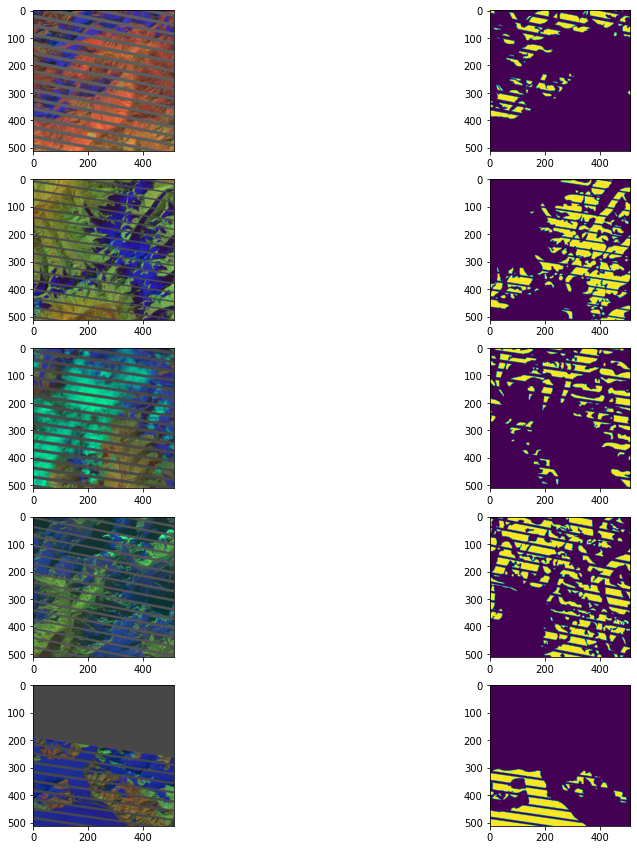

In [23]:
from glacier_mapping.data.slice import plot_slices
output_dir = pathlib.Path("/mnt/blobfuse/glaciers/processed")
plot_slices(output_dir / "train_main", processed=True, n_cols=2, div=1)

## train

In [20]:
from glacier_mapping.data.data import fetch_loaders
from glacier_mapping.models.frame import Framework
import glacier_mapping.models.metrics as mtr
import glacier_mapping.train as tr
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid
import torch
import json

data_dir = pathlib.Path("/mnt/blobfuse/glaciers")
conf = Dict(yaml.safe_load(open("/mnt/blobfuse/glaciers/conf/train.yaml", "r")))
processed_dir = data_dir / "processed"

args = Dict({
    "batch_size": 16,
    "run_name": "test_run",
    "epochs": 201,
    "save_every": 50
})

loaders = fetch_loaders(processed_dir, args.batch_size, train_folder="train_main", dev_folder="dev_main")
frame = Framework(
    model_opts=conf.model_opts,
    optimizer_opts=conf.optim_opts,
    reg_opts=conf.reg_opts
)

# Setup logging
writer = SummaryWriter(f"{data_dir}/runs/{args.run_name}/logs/")
writer.add_text("Arguments", json.dumps(vars(args)))
writer.add_text("Configuration Parameters", json.dumps(conf))
out_dir = f"{data_dir}/runs/{args.run_name}/models/"

for epoch in range(args.epochs):

    # train loop
    loss_d = {}
    loss_d["train"], metrics = tr.train_epoch(loaders["train"], frame, conf.metrics_opts)
    tr.log_metrics(writer, metrics, loss_d["train"], epoch)
    tr.log_images(writer, frame, next(iter(loaders["train"])), epoch)

    # validation loop
    loss_d["val"], metrics = tr.validate(loaders["val"], frame, conf.metrics_opts)
    tr.log_metrics(writer, metrics, loss_d["val"], epoch, "val")
    tr.log_images(writer, frame, next(iter(loaders["val"])), epoch, "val")

    # Save model"
    writer.add_scalars("Loss", loss_d, epoch)
    if epoch % args.save_every == 0:
        frame.save(out_dir, epoch)

    print(f"{epoch}/{args.epochs} | train: {loss_d['train']} | val: {loss_d['val']}")

frame.save(out_dir, "final")
writer.close()

0/201 | train: 1.9281169370997513 | val: 1.313737855924593
1/201 | train: 0.8997715516697798 | val: 0.5508634927389505
2/201 | train: 0.37269788281011246 | val: 0.23388278234255064
3/201 | train: 0.16845300850442563 | val: 0.11560447482795982
4/201 | train: 0.0872504193421711 | val: 0.06659131283526654
5/201 | train: 0.0560228353517584 | val: 0.04629237376726591


KeyboardInterrupt: 

In [77]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [79]:
%tensorboard --logdir runs/demo/logs